# Agent v2

Define a dictionary that contains metal prices per gram in USD. This data will be used as a reference for the model.

In [1]:
#Define the data available for the model
metal_data = {
    "unit":"gram",
    "currency": "USD",
    "prices": {
        "gold": 88.1553,
        "silver": 1.0523,
        "platinum": 32.169,
        "palladium": 35.8252,
        "copper": 0.0098,
        "aluminum": 0.0026,
        "lead": 0.0021,
        "nickel": 0.0159,
        "zinc": 0.0031,
    }
}

Define two tools that the agent can call: one to retrieve the current price of a metal, and another to return a simulated currency exchange rate between two currencies.

In [ ]:
from langchain_core.tools import tool

# Define the tools for the agent to use, it is necessary to specify that each function is a tool
@tool
def get_metal_price(metal_name: str) -> str:
    """Fetches the current per gram in USD price of the specified metal.

    Args:
        metal_name : The name of the metal (e.g., 'gold', 'silver', 'platinum').

    Returns:
        float: The current price of the metal in dollars per gram.

    Raises:
        KeyError: If the specified metal is not found in the data source.
    """
    try:
        metal_name = metal_name.lower().strip()
        prices = metal_data["prices"]
        currency = metal_data["currency"]
        unit=metal_data["unit"]
        if metal_name not in prices:
            raise KeyError(
                f"Metal {metal_name} not found."
            )
        price=prices[metal_name]
        return f"The current price of {metal_name} is {price} {currency} per {unit}."
    except Exception as e:
        raise Exception(f"Error fetching metal price: {str(e)}")
    
@tool    
def get_currency_exchange(base: str, target: str) -> str:
    """
    Returns the exchange rate from base currency to target currency.

    Args:
        base (str): The base currency (e.g., 'USD').
        target (str): The target currency (e.g., 'EUR').

    Returns:
        str: A human-readable string showing the exchange rate,
             or an error message if the pair is not found.
    """
    fake_rates = {
        ("usd", "eur"): 0.8,
        ("eur", "usd"): 1.8,
        ("usd", "gbp"): 0.7
    }
    rate = fake_rates.get((base.lower(), target.lower()))
    if rate is None:
        return f"No exchange rate found for {base.upper()} to {target.upper()}"
    return  f"{base.upper()} = {rate} {target.upper()}"



Initialise a local LLM with tool support and create a ReAct agent that can decide when to call each tool based on user input. The prompt specifies how the agent should reason when combining metal prices and currency exchange.


In [ ]:
from langchain_ollama.chat_models import ChatOllama
from langgraph.prebuilt import create_react_agent

# Create de model
llm = ChatOllama(
    model="llama3.2",   
    temperature=0
)

# Link the tools to the LLM
tools = [get_metal_price,get_currency_exchange]
llm_with_tools = llm.bind_tools(tools)

agent = create_react_agent(
    model=llm_with_tools,
    tools=[get_metal_price, get_currency_exchange],
    prompt="""
You are a ReAct agent. Read carefuly the dataset. For example: "What is the price of METAL in CURRENCY?":
1) Call get_metal_price with METAL.
2) Then call get_currency_exchange with base='USD', target=CURRENCY.
3) Finally, respond combining both results.


"""
)

Define the agent's state structure and create the first nodes of the graph: one for tool calls and one for the assistant's response. The assistant node invokes the ReAct agent and updates the conversation with the new messages.


In [4]:
from langgraph.prebuilt import ToolNode
from langgraph.graph import END
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages
from typing import Annotated
from typing_extensions import TypedDict

# 1) State
class GraphState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]

# 2) Nodes
tools = [get_metal_price,get_currency_exchange]
tool_node = ToolNode(tools)

def assistant(state: GraphState):
    result = agent.invoke({"messages": state["messages"]})
    new_msgs = result["messages"]
    return {"messages": state["messages"] + new_msgs}

Build and compile the graph by connecting the assistant node between the start and end states. This creates a simple one-step interaction flow for the ReAct agent.


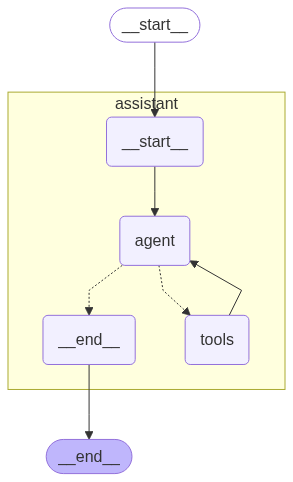

In [5]:
from langgraph.graph import START, StateGraph
from IPython.display import Image, display

# Define a new graph for the agent
builder = StateGraph(GraphState)

# Define the two nodes we will cycle between
builder.add_node("assistant", assistant)

builder.add_edge(START, "assistant")
builder.add_edge("assistant", END)

# Compile and display the graph for a visual overview
react_graph = builder.compile()
display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))

### Evaluation


In [ ]:
import asyncio
import json
import sys
import os
#sys.path.append(os.path.abspath("../Evaluations"))  
from utils import *
with open("qa_dataset_20_variaciones.json", "r") as f:
    qa_dataset = json.load(f)

results = asyncio.run(evaluate_agent_with_ragas(react_graph, qa_dataset,"Results/evaluation_v2.json"))

c:\Users\eguzk\anaconda3\envs\tfm_env\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Saved evaluation results to Results/evaluation_v2.json
